# Binary Classification Models for Student Outcome Prediction

## Objective
Build and compare supervised classification models to predict student binary outcomes: **At Risk (Fail/Withdrawn)** vs **Not at Risk (Pass/Distinction)** based on demographics and VLE engagement.

## CRISP-DM Stage
Modelling and Evaluation

## Models Implemented
- Logistic Regression (baseline, binary)
- Random Forest Classifier (binary)
- XGBoost Classifier (binary)
- Evaluation with Precision, Recall, F1-Score, Confusion Matrix

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import warnings
import re

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 1: Load Prepared Data

Load features and extract binary classification target (At Risk vs Not at Risk) from final_result.

In [2]:
print('Loading prepared data...')
features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_prepared.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'Features shape: {features.shape}')
print(f'Target shape: {target.shape}')

print('\n' + '=' * 80)
print('CREATING BINARY CLASSIFICATION TARGET (At Risk vs Not at Risk)')
print('=' * 80)

# Extract final_result as binary target
if 'final_result' in df_encoded.columns:
    target_class = df_encoded.loc[target.index, 'final_result']
else:
    raise ValueError('final_result column not found in df_encoded')

# Create binary target: Not at Risk (Pass, Distinction) vs At Risk (Fail, Withdrawn)
class_names = np.array(['Not at Risk', 'At Risk'])
target_class_encoded = np.where(target_class.isin(['Pass', 'Distinction']), 0, 1)

print(f'\nTarget classes: {list(class_names)}')
print(f'  0 = {class_names[0]}: Pass + Distinction')
print(f'  1 = {class_names[1]}: Fail + Withdrawn')
print(f'\nClassification target shape: {target_class_encoded.shape}')
print(f'\nClass distribution (full dataset):')
for cls_idx, cls_name in enumerate(class_names):
    count = (target_class_encoded == cls_idx).sum()
    pct = count / len(target_class_encoded) * 100
    print(f'  {cls_name}: {count} ({pct:.1f}%)')

Loading prepared data...
Features shape: (32593, 46)
Target shape: (32593,)

CREATING BINARY CLASSIFICATION TARGET (At Risk vs Not at Risk)

Target classes: [np.str_('Not at Risk'), np.str_('At Risk')]
  0 = Not at Risk: Pass + Distinction
  1 = At Risk: Fail + Withdrawn

Classification target shape: (32593,)

Class distribution (full dataset):
  Not at Risk: 15385 (47.2%)
  At Risk: 17208 (52.8%)


## Section 2: Train-Test Split

Divide data with stratification to maintain class balance.

In [3]:
print('\n' + '=' * 80)
print('TRAIN-TEST SPLIT (STRATIFIED)')
print('=' * 80)

X_train, X_test, y_train, y_test = train_test_split(
    features, target_class_encoded,
    test_size=0.2,
    random_state=42,
    stratify=target_class_encoded
)

print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')
print(f'\nClass distribution (training):')
for cls_idx in range(len(class_names)):
    count = (y_train == cls_idx).sum()
    pct = count / len(y_train) * 100
    print(f'  {class_names[cls_idx]}: {count} ({pct:.1f}%)')

print(f'\nClass distribution (testing):')
for cls_idx in range(len(class_names)):
    count = (y_test == cls_idx).sum()
    pct = count / len(y_test) * 100
    print(f'  {class_names[cls_idx]}: {count} ({pct:.1f}%)')


TRAIN-TEST SPLIT (STRATIFIED)
Training set size: (26074, 46)
Testing set size: (6519, 46)

Class distribution (training):
  Not at Risk: 12308 (47.2%)
  At Risk: 13766 (52.8%)

Class distribution (testing):
  Not at Risk: 3077 (47.2%)
  At Risk: 3442 (52.8%)


## Section 3: Logistic Regression Classifier

Implement baseline logistic regression for binary classification.

In [4]:
print('\n' + '=' * 80)
print('LOGISTIC REGRESSION (BASELINE)')
print('=' * 80)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)

acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log)
rec_log = recall_score(y_test, y_test_pred_log)
f1_log = f1_score(y_test, y_test_pred_log)
cv_scores_log = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')

print('\nLogistic Regression Results:')
print(f'  Accuracy:  {acc_log:.4f}')
print(f'  Precision: {prec_log:.4f}')
print(f'  Recall:    {rec_log:.4f}')
print(f'  F1-Score:  {f1_log:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_log.mean():.4f} (+/- {cv_scores_log.std():.4f})')

print('\nConfusion Matrix:')
cm_log = confusion_matrix(y_test, y_test_pred_log)
print(cm_log)
print('\nClassification Report:')
print(classification_report(y_test, y_test_pred_log, target_names=class_names))


LOGISTIC REGRESSION (BASELINE)

Logistic Regression Results:
  Accuracy:  0.9126
  Precision: 0.9650
  Recall:    0.8658
  F1-Score:  0.9127
  5-Fold CV Mean F1: 0.9165 (+/- 0.0018)

Confusion Matrix:
[[2969  108]
 [ 462 2980]]

Classification Report:
              precision    recall  f1-score   support

 Not at Risk       0.87      0.96      0.91      3077
     At Risk       0.97      0.87      0.91      3442

    accuracy                           0.91      6519
   macro avg       0.92      0.92      0.91      6519
weighted avg       0.92      0.91      0.91      6519



## Section 4: Random Forest Classifier

Implement ensemble classifier for non-linear patterns.

In [5]:
print('\n' + '=' * 80)
print('RANDOM FOREST CLASSIFIER')
print('=' * 80)

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)
cv_scores_rf = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1')

print('\nRandom Forest Results:')
print(f'  Accuracy:  {acc_rf:.4f}')
print(f'  Precision: {prec_rf:.4f}')
print(f'  Recall:    {rec_rf:.4f}')
print(f'  F1-Score:  {f1_rf:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})')

print('\nConfusion Matrix:')
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print(cm_rf)


RANDOM FOREST CLASSIFIER

Random Forest Results:
  Accuracy:  0.9235
  Precision: 0.9823
  Recall:    0.8707
  F1-Score:  0.9231
  5-Fold CV Mean F1: 0.9264 (+/- 0.0029)

Confusion Matrix:
[[3023   54]
 [ 445 2997]]


## Section 5: XGBoost Classifier

Apply gradient boosting for binary classification.

In [6]:
print('\n' + '=' * 80)
print('XGBOOST CLASSIFIER')
print('=' * 80)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='binary:logistic'
)

xgb_clf.fit(X_train, y_train, verbose=False)

y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb)
rec_xgb = recall_score(y_test, y_test_pred_xgb)
f1_xgb = f1_score(y_test, y_test_pred_xgb)
cv_scores_xgb = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='f1')

print('\nXGBoost Results:')
print(f'  Accuracy:  {acc_xgb:.4f}')
print(f'  Precision: {prec_xgb:.4f}')
print(f'  Recall:    {rec_xgb:.4f}')
print(f'  F1-Score:  {f1_xgb:.4f}')
print(f'  5-Fold CV Mean F1: {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})')

print('\nConfusion Matrix:')
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print(cm_xgb)


XGBOOST CLASSIFIER

XGBoost Results:
  Accuracy:  0.9258
  Precision: 0.9771
  Recall:    0.8800
  F1-Score:  0.9260
  5-Fold CV Mean F1: 0.9298 (+/- 0.0025)

Confusion Matrix:
[[3006   71]
 [ 413 3029]]


## Section 5b: Hyperparameter Optimisation

Tune each classifier using cross-validated search on the training set, then re-evaluate on the test set.

In [7]:
print('\n' + '=' * 80)
print('HYPERPARAMETER OPTIMISATION')
print('=' * 80)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Logistic Regression tuning
log_param_grid = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}
log_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=2000),
    param_grid=log_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
log_search.fit(X_train, y_train)
log_reg = log_search.best_estimator_

print(f"Best Logistic Regression params: {log_search.best_params_}")

# Random Forest tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
rf_clf = rf_search.best_estimator_

print(f"Best Random Forest params: {rf_search.best_params_}")

# XGBoost tuning (random search for speed)
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        objective='binary:logistic',
        eval_metric='logloss'
    ),
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
xgb_clf = xgb_search.best_estimator_

print(f"Best XGBoost params: {xgb_search.best_params_}")

# Re-evaluate using optimised models
print('\nRe-evaluating optimised models...')

y_train_pred_log = log_reg.predict(X_train)
y_test_pred_log = log_reg.predict(X_test)
acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log)
rec_log = recall_score(y_test, y_test_pred_log)
f1_log = f1_score(y_test, y_test_pred_log)
cm_log = confusion_matrix(y_test, y_test_pred_log)


y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)


y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb)
rec_xgb = recall_score(y_test, y_test_pred_xgb)
f1_xgb = f1_score(y_test, y_test_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print('Optimisation complete.')


HYPERPARAMETER OPTIMISATION
Best Logistic Regression params: {'C': 10, 'class_weight': 'balanced'}
Best Random Forest params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best XGBoost params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Re-evaluating optimised models...
Optimisation complete.


## Section 5d: SMOTE Resampling for Minority Classes

Apply SMOTE to training data only to balance Not at Risk class, then retrain optimised models.

In [8]:
print('\n' + '=' * 80)
print('SMOTE RESAMPLING')
print('=' * 80)

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Installing imbalanced-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn', '-q'])
    from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original training distribution:')
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f'  {class_names[cls]}: {cnt}')

print(f'\nAfter SMOTE:')
unique, counts = np.unique(y_train_smote, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f'  {class_names[cls]}: {cnt}')

# Retrain optimised models on SMOTE-resampled data
print(f'\nRetraining models on SMOTE-resampled data...')

log_reg.fit(X_train_smote, y_train_smote)
rf_clf.fit(X_train_smote, y_train_smote)
xgb_clf.fit(X_train_smote, y_train_smote, verbose=False)

# Get predictions from SMOTE-trained models
y_test_pred_log = log_reg.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)
y_test_pred_xgb = xgb_clf.predict(X_test)

# Re-evaluate with SMOTE-trained models
acc_log = accuracy_score(y_test, y_test_pred_log)
prec_log = precision_score(y_test, y_test_pred_log)
rec_log = recall_score(y_test, y_test_pred_log)
f1_log = f1_score(y_test, y_test_pred_log)
cm_log = confusion_matrix(y_test, y_test_pred_log)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
prec_rf = precision_score(y_test, y_test_pred_rf)
rec_rf = recall_score(y_test, y_test_pred_rf)
f1_rf = f1_score(y_test, y_test_pred_rf)
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
prec_xgb = precision_score(y_test, y_test_pred_xgb)
rec_xgb = recall_score(y_test, y_test_pred_xgb)
f1_xgb = f1_score(y_test, y_test_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)

print('\nSMOTE resampling and model retraining complete.')


SMOTE RESAMPLING
Original training distribution:
  Not at Risk: 12308
  At Risk: 13766

After SMOTE:
  Not at Risk: 13766
  At Risk: 13766

Retraining models on SMOTE-resampled data...

SMOTE resampling and model retraining complete.


## Section 6: Model Comparison and Visualisation

Compare classification models with confusion matrices and performance metrics.


CLASSIFICATION MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.915785   0.970713 0.866647  0.915733
      Random Forest  0.922994   0.981651 0.870424  0.922698
            XGBoost  0.924682   0.977354 0.877687  0.924843


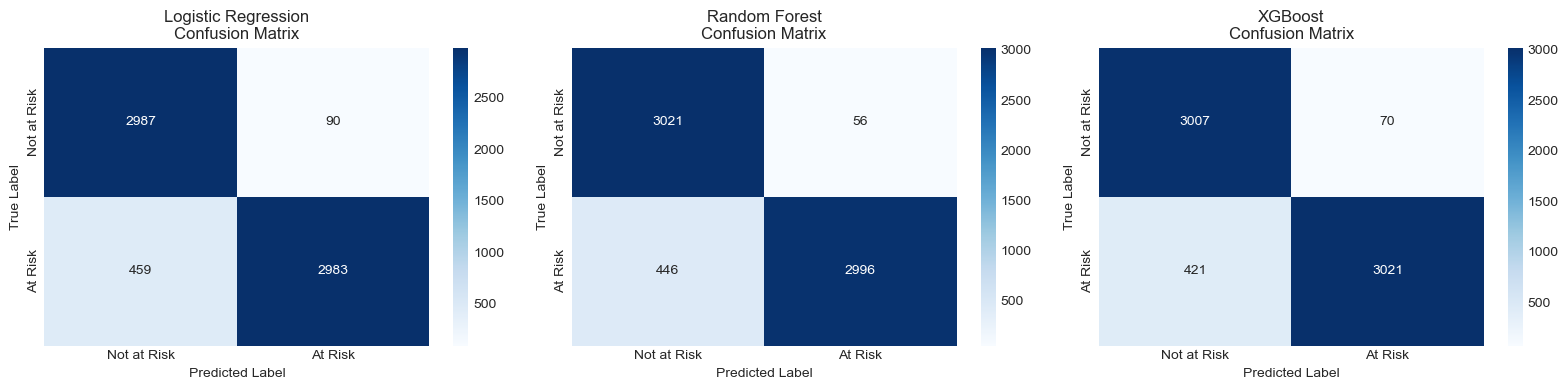

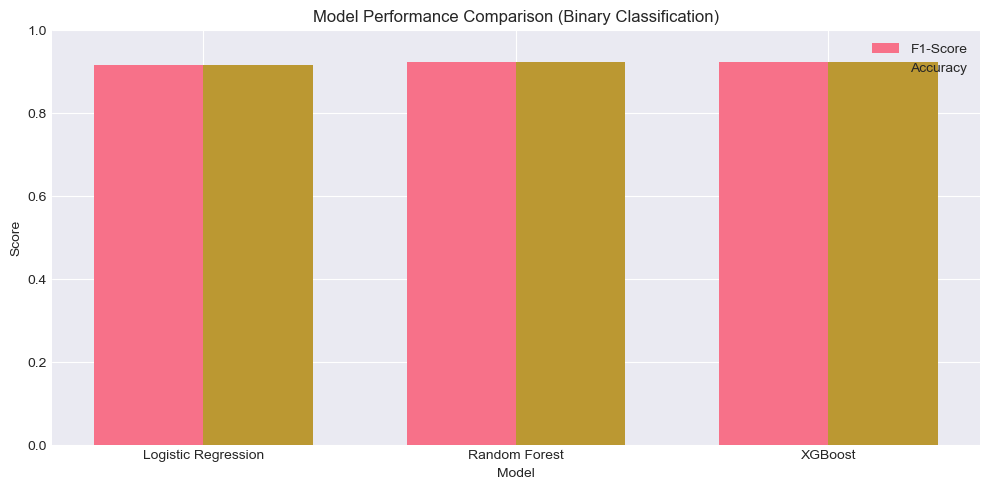


Best Model: XGBoost
F1-Score: 0.9248
Accuracy: 0.9247

Best model saved for final notebook


In [9]:
print('\n' + '=' * 80)
print('CLASSIFICATION MODEL COMPARISON')
print('=' * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [acc_log, acc_rf, acc_xgb],
    'Precision': [prec_log, prec_rf, prec_xgb],
    'Recall': [rec_log, rec_rf, rec_xgb],
    'F1-Score': [f1_log, f1_rf, f1_xgb]
})

print(comparison_df.to_string(index=False))

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
cms = [cm_log, cm_rf, cm_xgb]

for idx, (ax, title, cm) in enumerate(zip(axes, models, cms)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
    ax.set_title(f'{title}\nConfusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

plt.tight_layout()
plt.show()

# Plot model comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['F1-Score'], width, label='F1-Score')
ax.bar(x + width/2, comparison_df['Accuracy'], width, label='Accuracy')

ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Model Performance Comparison (Binary Classification)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_f1 = comparison_df.loc[best_model_idx, 'F1-Score']
best_acc = comparison_df.loc[best_model_idx, 'Accuracy']

print(f'\nBest Model: {best_model_name}')
print(f'F1-Score: {best_f1:.4f}')
print(f'Accuracy: {best_acc:.4f}')

# Save best model
if best_model_idx == 0:
    best_clf = log_reg
elif best_model_idx == 1:
    best_clf = rf_clf
else:
    best_clf = xgb_clf

import pickle
pickle.dump(best_clf, open('../2_Outputs/best_binary_classification_model.pkl', 'wb'))
print('\nBest model saved for final notebook')